To start this project, we outline it in several steps :
    Part 1: Setting up environment and loading data 
    Part 2: Data cleaning and basic visualization, EDA
    Part 3: Feature engineering, recompile data
    Part 4: Modeling and cross validation
    Part 5: Model selection and conclusions

Part 1: Setting up environment and loading raw data 
    In this part, we first make sure we have all the generic library and modeling tools. 
    Tools listed here includes pandas, numpy, scipy, scikit-learn, xgboost, lightgbm. We also preemptively installed lightgbm in in case other people wish to test my code
    We also loaded some tools for downcasting 64 bit to 32bit (used in the coursera projects)
    ____________________________________________________________________________________________________________________________________________________________________________________________

In [ ]:
!pip3 install lightgbm
##

In [ ]:
!pip install -U scikit-learn
#!pip install xgboost-0.81-cp37-cp37m-win_amd64.whl

In [132]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import os 
current_path = os.getcwd()
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import scipy.sparse 
import lightgbm 
import sklearn
import xgboost as xgb
import gc
from tabulate import tabulate

for p in [np, pd, scipy, sklearn, lightgbm]:
    print (p.__name__, p.__version__)
from math import sqrt
from numpy import loadtxt
from itertools import product
from tqdm import tqdm
from sklearn import preprocessing
from xgboost import plot_tree
from xgboost import plot_importance
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df


numpy 1.18.5
pandas 1.0.5
scipy 1.5.0
sklearn 0.24.2
lightgbm 3.2.1


In [2]:
sales = pd.read_csv('Dataset/sales_train.csv')
shops = pd.read_csv('Dataset/shops.csv')
items = pd.read_csv('Dataset/items.csv')
items_categories = pd.read_csv('Dataset/item_categories.csv')
sample_submission = pd.read_csv('Dataset/sample_submission.csv')
test_data = pd.read_csv('Dataset/test.csv')
print(sales.head(3))
print('\n')
print(shops.head(3))
print('\n')
print(items.head(3))
print('\n')
print(items_categories.head(3))
print('\n')

print(test_data.head(3))
print('\n')
print(sample_submission.head(3))


         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154       999.0           1.0
1  03.01.2013               0       25     2552       899.0           1.0
2  05.01.2013               0       25     2552       899.0          -1.0


                       shop_name  shop_id
0  !Якутск Орджоникидзе, 56 фран        0
1  !Якутск ТЦ "Центральный" фран        1
2               Адыгея ТЦ "Мега"        2


                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   

   item_category_id  
0                40  
1                76  
2                40  


        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2



Part 2: Data cleaning and basic visualization, EDA 
  In this part we identify that four features the original features used in the prediction. 
  First we plot display the unique items, shops, item categories and prices, and their respective mean, std,min and max , tease out apparent outliers and nonsensical values
  Then, we plot the time related (month number) series features. We also visualize them by histograms and plotting correlations we get insights if they are independent predictors
  In this step we found apparent high sales at some months that are 12 months from each other- we then hypothesize that the training dataset would need to include time (month) as a predictor
  Since test dataset does not provide us with this feature, we would need to design CV split to prevent overfit and underfit
  Next we perform feature engineering
  ____________________________________________________________________________________________________________________________________________________________________________________________


In [3]:
# # some EDA here, plot out popular items sale by ID
# because we will predict the item_cnt_day and logically the best available
# existing features are :  item_id, item_price, item_category_id, shop_id, 

# Before we start, ask yourself- how many unique items, and how many unique categories are there ?
# How many unique shops are there ? and how many unique prices are there ?

print('total unique items ')
print(sales['item_id'].nunique())
print('\n total unique shops')
print(shops['shop_id'].nunique())
print ()

print('total unique item categories ')
print(items_categories['item_category_id'].nunique())
print('\n total unique prices')
print(sales['item_price'].nunique())
print ()

total unique items 
21807

 total unique shops
60

total unique item categories 
84

 total unique prices
19993



In [4]:
sales.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2935849.0,14.569911,9.422988,0.0,7.0,14.0,23.0,33.0
shop_id,2935849.0,33.001728,16.226973,0.0,22.0,31.0,47.0,59.0
item_id,2935849.0,10197.227057,6324.297354,0.0,4476.0,9343.0,15684.0,22169.0
item_price,2935849.0,890.853233,1729.799631,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935849.0,1.242641,2.618834,-22.0,1.0,1.0,1.0,2169.0


In [5]:
items.describe().T

,count,mean,std,min,25%,50%,75%,max
item_id,22170.0,11084.500000,6400.072070,0.0,5542.25,11084.5,16626.75,22169.0
item_category_id,22170.0,46.290753,15.941486,0.0,37.00,40.0,58.00,83.0


1. Now we see that item_price has an outlier value -1. Price can't be negative, so here find the number of such record and impute 
2. item price also has max value much higher than mean+2*std, so need to visualize and decide
3. Traget value has outliers too. The items sold each day is 1.24+-2.618 while max and mean both were outside of the 2STD,. Need to visualize and impute

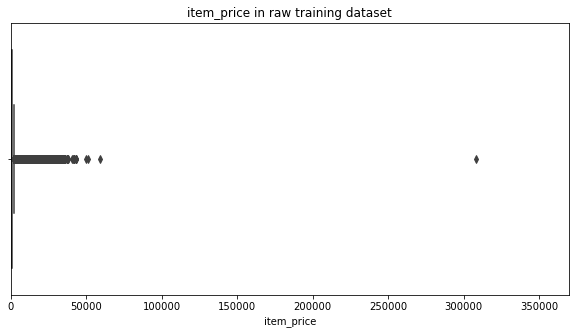

In [6]:
plt.figure(figsize=(10,5))
plt.xlim(sales.item_price.min(), sales.item_price.max()*1.2)
plt.title ('item_price in raw training dataset')
sns.boxplot(x=sales.item_price)

date_block_num      14.0
shop_id             31.0
item_id           9343.0
item_price         399.0
item_cnt_day         1.0
dtype: float64


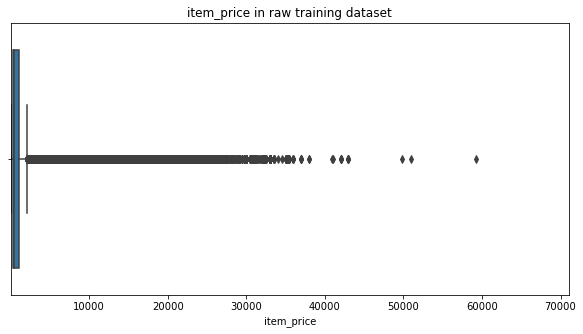

In [7]:
# now impute the data : for all values of item_price, find out the number of negative records
sales[sales.item_price<0].head(5)  # looks like only 1 price is negative, impute it with median values (can't use mean since its skewed by max)
priceimpute=sales[sales.item_price>0].median()
print(priceimpute)
sales.loc[sales.item_price<0,'item_price']=priceimpute.item_price
# We also see that items priced 300K is an outlier, impute it with median as well
sales[sales.item_price>90000].head(5)
sales.loc[sales.item_price>90000,'item_price']=priceimpute.item_price
plt.figure(figsize=(10,5))
plt.xlim(sales.item_price.min(), sales.item_price.max()*1.2)
plt.title ('item_price in raw training dataset')
sns.boxplot(x=sales.item_price)

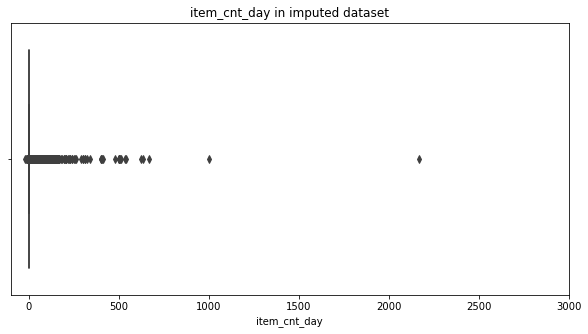

In [8]:
plt.figure(figsize=(10,5))
plt.xlim(-100, 3000)
plt.title ('item_cnt_day in imputed dataset')
sns.boxplot(x=sales.item_cnt_day)

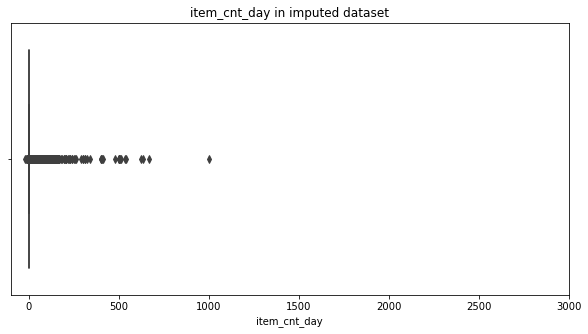

In [9]:
# we see that the training set target item_cnt_day has only 1 dataset above 2000
sales[sales.item_cnt_day>1000].head(5)
sales.loc[sales.item_cnt_day>1000,'item_cnt_day']=priceimpute.item_cnt_day
plt.figure(figsize=(10,5))
plt.xlim(-100, 3000)
plt.title ('item_cnt_day in imputed dataset')
sns.boxplot(x=sales.item_cnt_day)

Text(0.5, 1.0, 'Popular items')

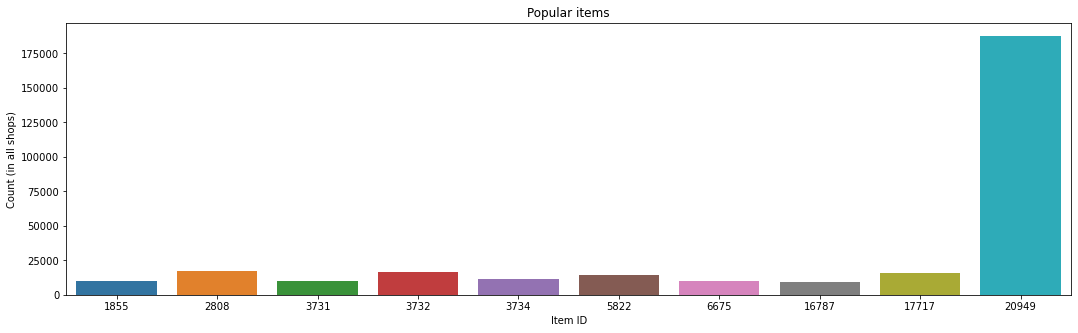

In [10]:
# Visualize the items popularity
popularitems = sales.groupby('item_id')['item_cnt_day'].sum()
popularitems = popularitems.sort_values(ascending=False)[:10]

fig, ax = plt.subplots(figsize=(18, 5))
sns.barplot(popularitems.index, popularitems.values, ax=ax)
plt.xlabel("Item ID")
plt.ylabel("Count (in all shops)")
plt.title("Popular items")
# looks like item 20949 has significantly higher sales count at 175K, others are all below 25K - is that an error ?


Text(0.5, 1.0, 'Popular shops')

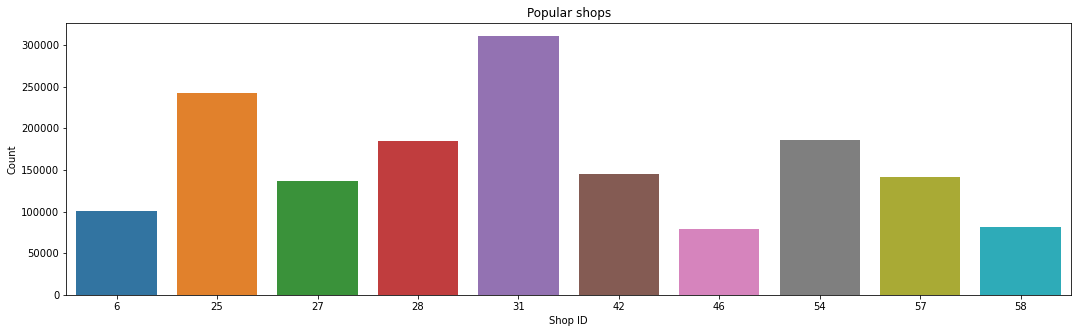

In [11]:
# visualize the popular shop IDs, only the top 10
popularshops = sales.groupby('shop_id')['item_cnt_day'].sum()
popularshops = popularshops.sort_values(ascending=False)[:10]
fig, ax = plt.subplots(figsize=(18, 5))
sns.barplot(popularshops.index, popularshops.values)
plt.xlabel("Shop ID")
plt.ylabel("Count")
plt.title("Popular shops")

84

[5035 2365 1780 1125  790  756  666  628  598  501]


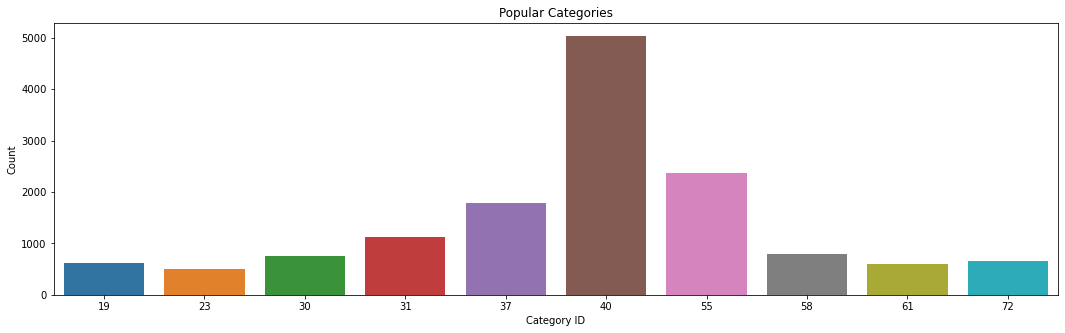

In [12]:
# visualize the popularitemcategories
# display the top 10 categories, each with unique number of item ID counts
popularcategories = items.groupby('item_category_id')['item_id'].nunique()
popularcategories = popularcategories.sort_values(ascending=False)[:10]
fig, ax = plt.subplots(figsize=(18, 5))
sns.barplot(popularcategories.index, popularcategories.values)
plt.xlabel("Category ID")
plt.ylabel("Count")
plt.title("Popular Categories")

print(items_categories['item_category_id'].nunique())
print()
print(popularcategories.unique())
# looks like category 40 is very popular

Text(0.5, 1.0, 'Number of items sold in each month')

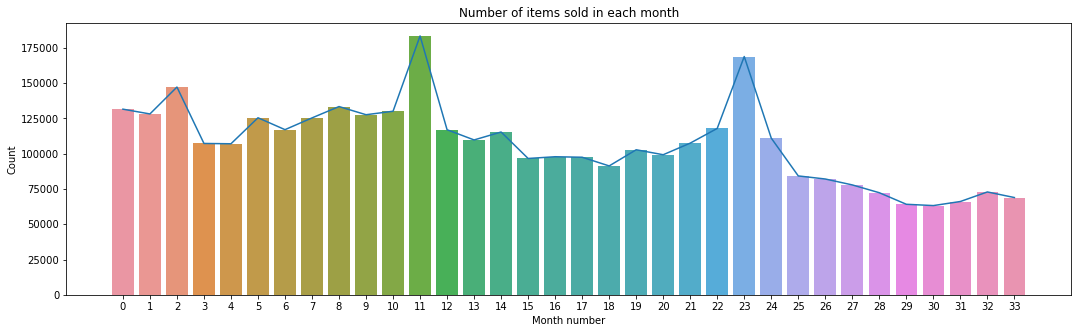

In [13]:
# Visualize the number of items sold in each month
item_cnt_month = sales.groupby('date_block_num')['item_cnt_day'].sum()
fig, ax = plt.subplots(figsize=(18, 5))
sns.barplot(item_cnt_month.index, item_cnt_month.values)
plt.plot(item_cnt_month.index, item_cnt_month.values)
plt.xlabel("Month number")
plt.ylabel("Count")
plt.title("Number of items sold in each month")
# looks like November (11th and 23th of the data series) is the has the highest sales.

In [ ]:
# Visualize the revenue of each month (summed price*item_cnt_day)
#sale['Revenue']=dot(sales['item_cnt_day'],sales['item_cnt_price'])
sales['Revenue']=(sales['item_cnt_day']*sales['item_price'])
monthlyrevenue=sales.groupby('date_block_num')['Revenue'].sum()
fig, ax = plt.subplots(figsize=(18, 5))
sns.barplot(monthlyrevenue.index, monthlyrevenue.values)
plt.plot(monthlyrevenue.index, monthlyrevenue.values)
plt.xlabel("Month number")
plt.ylabel("Revenue")
plt.title("Monthly Revenue ")
# looks like November 2013 and 2014 (11th and 23th of the data series)has the highest sales.

In [14]:
sales.head(5).T

,0,1,2,3,4
date,02.01.2013,03.01.2013,05.01.2013,06.01.2013,15.01.2013
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999,899,899,1709.05,1099
item_cnt_day,1,1,-1,1,1


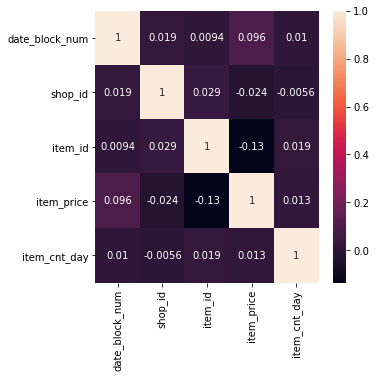

In [15]:
# finally we plot the correlation coefficients between these main features
#ploting the heatmap for correlation
fig, ax = plt.subplots(figsize=(5,5))
ax = sns.heatmap(sales.corr(), annot=True)
# we can see that the ID has some correlation with respect to item_price; furthermore the date_block number may be related with item_price. 
# Revenue is correlated with price and count per day- as expected when we feature engineer revenue

Part 3 We are recompiling data and added more  feature engineering here 
#_________________________________________________________________________________________________________

In [22]:
train = sales.join(items, on='item_id', rsuffix='_').\
join(shops, on='shop_id', rsuffix='_').\
join(items_categories, on='item_category_id',\
     rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)
train.head(5).T

,0,1,2,3,4
date,02.01.2013,03.01.2013,05.01.2013,06.01.2013,15.01.2013
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999,899,899,1709.05,1099
item_cnt_day,1,1,-1,1,1
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
item_category_id,37,58,58,58,56
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_category_name,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил,Музыка - Винил,Музыка - CD фирменного производства


In [23]:
# examine the train and test dataset size, determine the leakage. Our strategy
# is to train from a subset of data whose features have appeared in the test dataset
# thus in this initial model building we expect to avoid underfitting

print('test data size and unique shop_id and item_id ')
print(test_data.shape) 
print(test_data.shop_id.nunique())
print(test_data.item_id.nunique())
print()
print('train data size and unique shop_id and item_id ')
print(train.shape)
print(train.shop_id.nunique())
print(train.item_id.nunique())

# because the test dataset size is 
testunique_shop_ids = test_data['shop_id'].unique()
testunique_item_ids = test_data['item_id'].unique()
# Only shops that exist in test set.
overfittrain1 = train[train['shop_id'].isin(testunique_shop_ids)]
# Only items that exist in test set.
overfittrain2 = overfittrain1[overfittrain1['item_id'].isin(testunique_item_ids)]
print('Data size for the to-be-overfit training set')
print(overfittrain2.shape)


test data size and unique shop_id and item_id 
(214200, 3)
42
5100

train data size and unique shop_id and item_id 
(2935849, 10)
60
21807
Data size for the to-be-overfit training set
(1224439, 10)


In [24]:
overfittrain2.head().T

,0,10,11,12,13
date,02.01.2013,03.01.2013,05.01.2013,07.01.2013,08.01.2013
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2574,2574,2574,2574
item_price,999,399,399,399,399
item_cnt_day,1,2,1,1,2
item_name,ЯВЛЕНИЕ 2012 (BD),DEL REY LANA Born To Die The Paradise Editio...,DEL REY LANA Born To Die The Paradise Editio...,DEL REY LANA Born To Die The Paradise Editio...,DEL REY LANA Born To Die The Paradise Editio...
item_category_id,37,55,55,55,55
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_category_name,Кино - Blu-Ray,Музыка - CD локального производства,Музыка - CD локального производства,Музыка - CD локального производства,Музыка - CD локального производства


In [40]:
# drop the text features since the categories and names are unique
train_monthly = overfittrain2[['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day', 'item_category_id']]
train_monthly.head(5)
#print(train_monthly.shape[0])

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.0,1.0,37
10,03.01.2013,0,25,2574,399.0,2.0,55
11,05.01.2013,0,25,2574,399.0,1.0,55
12,07.01.2013,0,25,2574,399.0,1.0,55
13,08.01.2013,0,25,2574,399.0,2.0,55


In [41]:
train_monthly.date.describe().T

count        1224439
unique          1034
top       30.12.2014
freq            5672
Name: date, dtype: object

In [42]:
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
# Rename features.
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']
# note that transaction is the count of item_cnt in that month, just rename features here , get rid of second-level feature names

In [43]:
train_monthly.head().T

,0,1,2,3,4
date_block_num,0.000000,0.000,0.00,0.0,0.0
shop_id,2.000000,2.000,2.00,2.0,2.0
item_category_id,2.000000,2.000,5.00,6.0,6.0
item_id,5572.000000,5643.000,5583.00,7893.0,7894.0
item_price,10730.000000,4775.210,1188.30,5970.0,1490.0
mean_item_price,1532.857143,2387.605,594.15,1990.0,1490.0
item_cnt,9.000000,0.000,2.00,3.0,1.0
mean_item_cnt,1.285714,0.000,1.00,1.0,1.0
transactions,7.000000,2.000,2.00,3.0,1.0


In [44]:
shop_ids = train_monthly['shop_id'].nunique()
item_ids = train_monthly['item_id'].nunique()
month_no = train_monthly['date_block_num'].nunique()
print(shop_ids)
print(item_ids)
print(month_no)
print('total possible combinations of unique shop_id, item_id and month is')
print(shop_ids*item_ids*month_no)

42
4716
34
total possible combinations of unique shop_id, item_id and month is
6734448


 Because the ultimate target prediction utilizes only shop_id, item_id and month_no, 3 features, and
theoretically these 3 features generates 6.7m combinations, while in the to-over-fit train sets has only 0.6m entries, we expect this matrix to be
relatively sparse if we build a feature matrix ; this steps takes a few seconds


In [45]:

# Now rebuild the train dataset that has all possible shop_id, item_id and month_no, fill zeros if train_monthly do not have it 
shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()

empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])
# Merge the train set with the complete set (missing records will be filled with 0). use merge left to ensure all 3 features have all possible values



In [46]:
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)

In [47]:
# Sanity check - compare this table with the previous table. If done correctly the min max should be the same , count increased to 673448
# while mean, std, etc changes
train_monthly.head().T

,0,1,2,3,4
date_block_num,0.000000,0.000,0.00,0.0,0.0
shop_id,2.000000,2.000,2.00,2.0,2.0
item_id,5572.000000,5643.000,5583.00,7893.0,7894.0
item_category_id,2.000000,2.000,5.00,6.0,6.0
item_price,10730.000000,4775.210,1188.30,5970.0,1490.0
mean_item_price,1532.857143,2387.605,594.15,1990.0,1490.0
item_cnt,9.000000,0.000,2.00,3.0,1.0
mean_item_cnt,1.285714,0.000,1.00,1.0,1.0
transactions,7.000000,2.000,2.00,3.0,1.0


In [48]:
train_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6734448 entries, 0 to 6734447
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date_block_num    int64  
 1   shop_id           int64  
 2   item_id           int64  
 3   item_category_id  float64
 4   item_price        float64
 5   mean_item_price   float64
 6   item_cnt          float64
 7   mean_item_cnt     float64
 8   transactions      float64
dtypes: float64(6), int64(3)
memory usage: 513.8 MB


re-check outliers in the training dataset - note, it is a kind of repetition routine
previous outlier checking was done using the raw sales dataset; this one deals with 
leak-proof dataset in which only item_id and shop_id appears both in train and test dataset
in addition, previous outlier cleaning deals with cnt_day while here we deal with monthly item_cnt
here, we use a different outlier identification strategy, we scatterplot the monthly item_cnt (the target) with respect to 
item_price , as well as transactions+


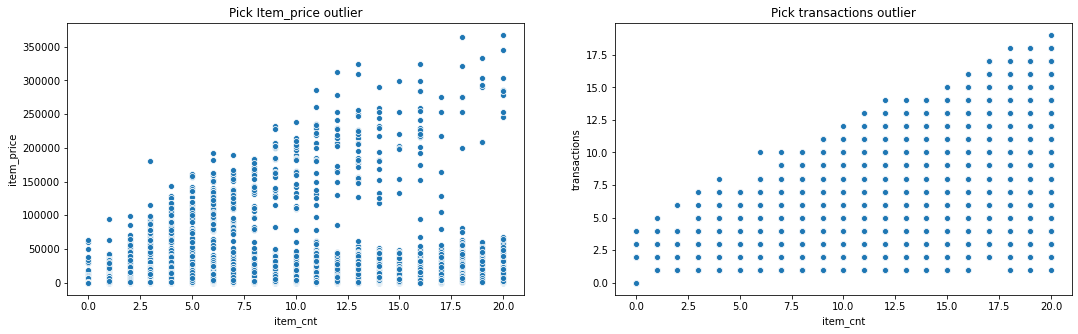

In [49]:
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20 and item_price < 400000')  
# set max item_cnt, meaning the target, to be less than 20- competition requirement


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(18,5))
ax1.set_title('Pick Item_price outlier')
sns.scatterplot(x='item_cnt', y='item_price', data=train_monthly, ax=ax1)

ax2.set_title('Pick transactions outlier')
sns.scatterplot(x='item_cnt', y='transactions', data=train_monthly, ax=ax2)

# looks like no apparent outlier is found here. The previous step in teasing out raw data outlier was sufficient


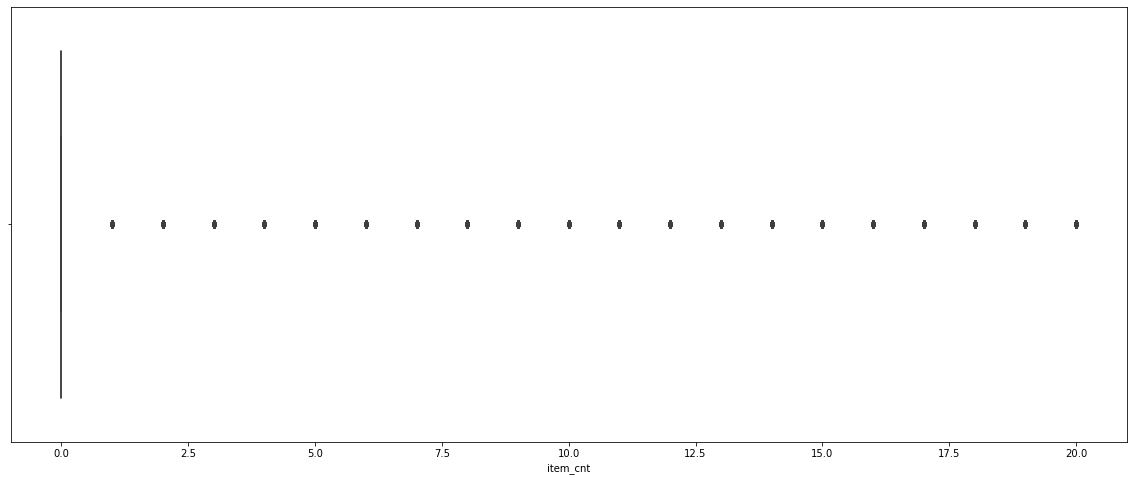

In [50]:
plt.subplots(figsize=(20, 8))
sns.boxplot(train_monthly['item_cnt'])
plt.show()
# this is monthly item count 

In [51]:
# Feature engineering - adding some more time features
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12+1))  

# make target feature here, embed into the training set
# because the target feature is 1 month after the training feature, shift it using -1
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

In [52]:
# Feature engineering   - time lag based features for time series
# make item_cnt feature with lag of 1,2,3 months
lag_list = [1, 2, 3]
for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    train_monthly[ft_name].fillna(0, inplace=True)

In [53]:
# Feature engineering - adding rolling window , last 3 month mean- this process takes some time so please be patient
# since first 2 months will be useless for NA values, drop these  
train_monthly['Roll3mean']=train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(lambda x: x.rolling(window=3, min_periods=1).mean())
#train_monthly= train_monthly.iloc[:, [0, 1,2,3,4,5,6,7,8,9,10,11,12,13,15,14]]

In [54]:
train_monthly.head(5).T
train_monthly=train_monthly[['date_block_num','shop_id','item_id','item_category_id','item_price','mean_item_price','item_cnt','transactions','Roll3mean','year','month','item_cnt_shifted1','item_cnt_shifted2','item_cnt_shifted3','item_cnt_month']]
# move the target variable item_cnt_month to the last row            

In [55]:
train_monthly.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6728118.0,16.498777,9.811429,0.0,8.0,16.0,25.0,33.0
shop_id,6728118.0,31.643428,17.563488,2.0,16.0,35.0,47.0,59.0
item_id,6728118.0,11042.868904,6209.703870,30.0,5386.0,11266.0,16068.0,22167.0
item_category_id,6728118.0,3.752608,13.156585,0.0,0.0,0.0,0.0,83.0
item_price,6728118.0,169.801052,1797.753805,0.0,0.0,0.0,0.0,366860.0
mean_item_price,6728118.0,79.816626,525.620638,0.0,0.0,0.0,0.0,42990.0
item_cnt,6728118.0,0.185153,0.907449,0.0,0.0,0.0,0.0,20.0
transactions,6728118.0,0.167633,0.743099,0.0,0.0,0.0,0.0,19.0
Roll3mean,6728118.0,0.197768,0.915561,0.0,0.0,0.0,0.0,20.0
year,6728118.0,2013.941146,0.802274,2013.0,2013.0,2014.0,2015.0,2015.0


In [56]:
train_monthly.head(5).T

,0,1,2,3,4
date_block_num,0.000000,0.000,0.00,0.0,0.0
shop_id,2.000000,2.000,2.00,2.0,2.0
item_id,5572.000000,5643.000,5583.00,7893.0,7894.0
item_category_id,2.000000,2.000,5.00,6.0,6.0
item_price,10730.000000,4775.210,1188.30,5970.0,1490.0
mean_item_price,1532.857143,2387.605,594.15,1990.0,1490.0
item_cnt,9.000000,0.000,2.00,3.0,1.0
transactions,7.000000,2.000,2.00,3.0,1.0
Roll3mean,9.000000,0.000,2.00,3.0,1.0
year,2013.000000,2013.000,2013.00,2013.0,2013.0


next we are going to mean encode the categorical features to numeric ones. 
here the shop_id, item_id,item_category_id are categorical features. In addition, year, month are also categorical features. We should mean encode
them to allow better separation of the data
this step has to be done AFTER the Train/Validation Split - see next block of codes

here we have date_block_num from 0 to 33. Because validation dataset of timeseries can't happen before training
we will just pick month 3 (march 2013, disregard Jan,Feb since we used lag3 features) to month 27 (April 2015) , total of 15 month, as training 
will pick the other 5 month (month28-32) as validation set (May 2015 to September 2015)
we then use october 2015 dataset as test set- note, we will switch it to the real test set upon submission (Nov 2015)

In [57]:

test_data = pd.read_csv('Dataset/test.csv')
train_set = train_monthly.query('date_block_num >= 3 and date_block_num < 28').copy()   # note this is by default deep copy.
validation_set = train_monthly.query('date_block_num >= 28 and date_block_num < 33').copy()
test_set = train_monthly.query('date_block_num == 33').copy()
train_set.dropna(subset=['item_cnt_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_month'], inplace=True)
print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])
print('Test set records:', test_set.shape[0])

print('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/train_monthly.shape[0])*100)))
print('Validation set records: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/train_monthly.shape[0])*100)))


Train set records: 4946785
Validation set records: 989412
Test set records: 197879
Train set records: 4946785 (74% of complete data)
Validation set records: 989412 (15% of complete data)


In [58]:
# mean encoding the categorical features :  - MUST use merge method, do not use "Transform (mean)"
# shop_id, item_id, item_category_id, year, month
# Shop mean encoding.
shop_enc = train_set.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
shop_enc.columns = ['shop_enc']
shop_enc.reset_index(inplace=True)
# Item mean encoding.
item_enc = train_set.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
item_enc.columns = ['item_enc']
item_enc.reset_index(inplace=True)
# Year mean encoding.
year_enc = train_set.groupby(['year']).agg({'item_cnt_month': ['mean']})
year_enc.columns = ['year_enc']
year_enc.reset_index(inplace=True)
# Month mean encoding.
month_enc = train_set.groupby(['month']).agg({'item_cnt_month': ['mean']})
month_enc.columns = ['month_enc']
month_enc.reset_index(inplace=True)

# Here you must use merge instead of directly transform. We wish to keep these mean encodes and original shop ,item year , etc features
train_set = pd.merge(train_set, shop_enc, on=['shop_id'], how='left')
train_set = pd.merge(train_set, item_enc, on=['item_id'], how='left')
train_set = pd.merge(train_set, year_enc, on=['year'], how='left')
train_set = pd.merge(train_set, month_enc, on=['month'], how='left')
# Add meand encoding features to validation set.
validation_set = pd.merge(validation_set, shop_enc, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, item_enc, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, year_enc, on=['year'], how='left')
validation_set = pd.merge(validation_set, month_enc, on=['month'], how='left')

In [59]:
# Create train and validation sets and labels. 
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)
Y_train = pd.DataFrame (Y_train)  
# convert datatype to conform
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
# Note, we already know that X_train has date_block_num that is 3-27, and X_validation is 28-32
Y_validation = validation_set['item_cnt_month'].astype(int)
Y_validation = pd.DataFrame (Y_validation)
#train_set=pd.merge(train_set, shopidenc,on=['shop_id'],how='left')

In [60]:
Y_validation.head(5).T
X_train=downcast_dtypes(X_train)
Y_train=downcast_dtypes(Y_train)
X_validation=downcast_dtypes(X_validation)
Y_validation=downcast_dtypes(Y_validation)


In [61]:
train_monthly.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6728118.0,16.498777,9.811429,0.0,8.0,16.0,25.0,33.0
shop_id,6728118.0,31.643428,17.563488,2.0,16.0,35.0,47.0,59.0
item_id,6728118.0,11042.868904,6209.703870,30.0,5386.0,11266.0,16068.0,22167.0
item_category_id,6728118.0,3.752608,13.156585,0.0,0.0,0.0,0.0,83.0
item_price,6728118.0,169.801052,1797.753805,0.0,0.0,0.0,0.0,366860.0
mean_item_price,6728118.0,79.816626,525.620638,0.0,0.0,0.0,0.0,42990.0
item_cnt,6728118.0,0.185153,0.907449,0.0,0.0,0.0,0.0,20.0
transactions,6728118.0,0.167633,0.743099,0.0,0.0,0.0,0.0,19.0
Roll3mean,6728118.0,0.197768,0.915561,0.0,0.0,0.0,0.0,20.0
year,6728118.0,2013.941146,0.802274,2013.0,2013.0,2014.0,2015.0,2015.0


In [62]:
# Construct test set, predict month 11 data
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
X_test = pd.merge(test_data, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])

# assuming that the test data has all other features (other than shopId and ItemId) identical to the merged pool of training/validation set
# 
X_test['year'] = 2015
X_test['month'] = 11

X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test = X_test[X_train.columns]


In [103]:
X_test.describe().T

,count,mean,std,min,25%,50%,75%,max
shop_id,214200.0,31.642857,17.561933,2.000000,16.000000,34.500000,47.000000,59.000000
item_id,214200.0,11019.398627,6252.644590,30.000000,5381.500000,11203.000000,16071.500000,22167.000000
item_category_id,214200.0,5.110177,15.030258,0.000000,0.000000,0.000000,0.000000,83.000000
item_price,214200.0,239.964584,1852.605078,0.000000,0.000000,0.000000,0.000000,166944.500000
mean_item_price,214200.0,133.806258,865.993984,0.000000,0.000000,0.000000,0.000000,32990.000000
item_cnt,214200.0,0.229561,0.946355,0.000000,0.000000,0.000000,0.000000,20.000000
transactions,214200.0,0.203992,0.730291,0.000000,0.000000,0.000000,0.000000,15.000000
Roll3mean,214200.0,0.245407,0.948812,0.000000,0.000000,0.000000,0.000000,20.000000
year,214200.0,2015.000000,0.000000,2015.000000,2015.000000,2015.000000,2015.000000,2015.000000
month,214200.0,11.000000,0.000000,11.000000,11.000000,11.000000,11.000000,11.000000


In [64]:
# Replace missing values with the median of each shop.  This step takes some time please be patient   
# this applies to all X datasets
sets = [X_train, X_validation, X_test]
for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            # choose media ID to avoid na
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median
            
# Fillna 
X_test.fillna(X_test.mean(), inplace=True)

In [65]:
X_test.head().T

,0,1,2,3,4
shop_id,5.000000,5.000000,5.000000,5.000000,5.000000
item_id,5037.000000,5320.000000,5233.000000,5232.000000,5268.000000
item_category_id,19.000000,0.000000,19.000000,0.000000,0.000000
item_price,749.500000,0.000000,2997.000000,0.000000,0.000000
mean_item_price,749.500000,0.000000,999.000000,0.000000,0.000000
item_cnt,1.000000,0.000000,3.000000,0.000000,0.000000
transactions,1.000000,0.000000,3.000000,0.000000,0.000000
Roll3mean,1.666667,0.000000,2.000000,0.000000,0.000000
year,2015.000000,2015.000000,2015.000000,2015.000000,2015.000000
month,11.000000,11.000000,11.000000,11.000000,11.000000


 Part 4 model development ###############
In the first level, we do Linear Regression First
we can see that all the features have scales of differences
so to perform linear model a good idea is to transform to standard scale before fitting


In [107]:
X_train.describe()

,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,transactions,Roll3mean,year,month,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,shop_enc,item_enc,year_enc,month_enc
count,4.946785e+06,4.946785e+06,4.946785e+06,4.946785e+06,4.946785e+06,4.946785e+06,4.946785e+06,4.946785e+06,4.946785e+06,4.946785e+06,4.946785e+06,4.946785e+06,4.946785e+06,4.946785e+06,4.946785e+06,4.946785e+06,4.946785e+06
mean,3.164328e+01,1.104290e+04,3.536714e+00,1.646617e+02,7.224959e+01,1.816922e-01,1.638921e-01,1.944194e-01,2.013800e+03,6.399032e+00,1.634033e-01,1.449685e-01,1.277050e-01,1.859361e-01,1.858834e-01,1.874578e-01,1.887586e-01
std,1.756343e+01,6.209505e+03,1.258792e+01,1.888577e+03,4.636528e+02,9.118031e-01,7.418146e-01,9.170049e-01,6.928318e-01,3.417091e+00,8.955635e-01,8.726352e-01,8.432840e-01,1.262052e-01,4.130845e-01,3.825037e-02,4.432446e-02
min,2.000000e+00,3.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.350413e-01,1.408064e-01
25%,1.600000e+01,5.386000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.209202e-01,3.809524e-03,1.350413e-01,1.573196e-01
50%,3.500000e+01,1.126600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.014000e+03,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.650255e-01,5.333333e-02,2.126916e-01,1.721077e-01
75%,4.700000e+01,1.606800e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.014000e+03,9.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.046153e-01,1.954242e-01,2.126916e-01,2.029810e-01
max,5.900000e+01,2.216700e+04,8.300000e+01,3.668600e+05,3.349000e+04,2.000000e+01,1.900000e+01,2.000000e+01,2.015000e+03,1.200000e+01,2.000000e+01,2.000000e+01,2.000000e+01,6.802957e-01,6.972281e+00,2.249501e-01,3.155235e-01


In [67]:
# XGB tree method
xgb_features = ['item_cnt','item_enc', 'item_cnt_shifted1', 
                'item_cnt_shifted2', 'item_cnt_shifted3', 'Roll3mean', 'shop_id', 
                'item_id',  'shop_enc','year_enc','month_enc']
xgb_train = X_train[xgb_features]
xgb_val = X_validation[xgb_features]
xgb_test = X_test[xgb_features]

In [75]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(max_depth=8, 
                         n_estimators=100,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.3, 
                         seed=1234)
xgb_model.fit(xgb_train, 
              Y_train, 
              eval_metric="rmse",    
              # metrics must be RMSE according to competition guideline
              eval_set=[(xgb_train, Y_train), (xgb_val, Y_validation)], 
              verbose=20, 
              early_stopping_rounds=20)              # at least 20 iterations

[0]	validation_0-rmse:0.86811	validation_1-rmse:0.89462
[20]	validation_0-rmse:0.66284	validation_1-rmse:0.77604
[29]	validation_0-rmse:0.65700	validation_1-rmse:0.77675


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1,
             random_state=1234, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=1234, subsample=0.7, tree_method='approx',
             validate_parameters=1, verbosity=None)

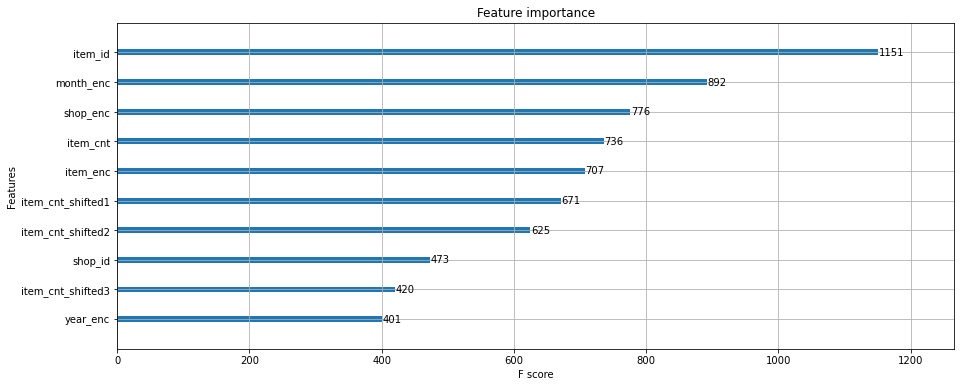

In [76]:
#from xgboost import plot_importance
plt.rcParams["figure.figsize"] = (15, 8)
plot_importance(xgb_model)
plt.show()

In [81]:
# Finalize predictino for XGBoost tree models
Y_train_XGB=xgb_model.predict(xgb_train).clip(0, 20)
Y_validation_XGB=xgb_model.predict(xgb_val).clip(0,20)
Y_test_XGB=xgb_model.predict(xgb_test).clip(0,20)
print('Training RMSE',np.sqrt(mean_squared_error(Y_train, Y_train_XGB)))
print('Validation RMSE',np.sqrt(mean_squared_error(Y_validation, Y_validation_XGB)))
# we added clip (0,20) here just to make sure submission conforms with the competition requirement

Training RMSE 0.6759963939051377
Validation RMSE 0.7742578314451641


In [101]:
Y_test_XGB[:5]

array([0.7301441, 0.0820278, 1.0093253, 0.024656 , 0.0820278],
      dtype=float32)

In [ ]:
# Generate submission file 


Secondly, we want to use random forest (RF) to train this. RF should expect to avoid overfitting problem given the randomness
We will use the same feature set as used in the gradient boosted decision tree 

In [83]:
# Use the same feature list in random forest
rf_features = ['item_cnt','item_enc', 'item_cnt_shifted1', 
                'item_cnt_shifted2', 'item_cnt_shifted3', 'Roll3mean', 'shop_id', 
                'item_id',  'shop_enc','year_enc','month_enc']
rf_train = X_train[rf_features]
rf_val = X_validation[rf_features]
rf_test = X_test[rf_features]

In [85]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=50, max_depth=8, random_state=1234, n_jobs=-1)
rf_model.fit(rf_train, Y_train)

<ipython-input-85-ec15d286980b>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(rf_train, Y_train)


RandomForestRegressor(max_depth=8, n_estimators=50, n_jobs=-1,
                      random_state=1234)

In [98]:
Y_train_rf = rf_model.predict(rf_train).clip(0,20)
Y_validation_rf = rf_model.predict(rf_val).clip(0,20)
Y_test_rf = rf_model.predict(rf_test).clip(0,20)

In [99]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, Y_train_rf)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, Y_validation_rf)))

Train rmse: 0.6859762713754348
Validation rmse: 0.7804586758720266


In [100]:
Y_test_rf[:5]

array([9.01331999e-01, 4.95002479e-02, 8.26533963e-01, 5.35868320e-05,
       4.95002479e-02])

Thirdly we are going to use KNN cluster method. KNN is slow for datasize of training (since we have 4 million+ instances), but may be ok for the validation (~ 1m)and test data (200K)size.
I decide to cut the training dataset
cut training set to 250k and keep validation to ~1m

In [156]:
knn_features = ['item_cnt','item_enc', 'item_cnt_shifted1', 
                'item_cnt_shifted2', 'item_cnt_shifted3', 'Roll3mean', 'shop_id', 
                'item_id',  'shop_enc','year_enc','month_enc']
X_train_sampled = X_train[:250000]
Y_train_sampled = Y_train[:250000]
X_validation_sampled = X_validation
Y_validation_sampled = Y_validation

X_train_knn = X_train_sampled[knn_features]
X_validation_knn = X_validation_sampled[knn_features]
X_test_knn = X_test[knn_features]

In [157]:
knn_scaler = MinMaxScaler()
knn_scaler.fit(X_train_knn)
X_train_knn = knn_scaler.transform(X_train_knn)
X_validation_knn = knn_scaler.transform(X_validation_knn)
X_test_knn = knn_scaler.transform(X_test_knn)

In [158]:
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsRegressor(n_neighbors=7, leaf_size=13, n_jobs=-1)
# we chose 7 here for convenience. could be others. Since knn is only a weak learner and takes long time for this
#dataset size, I did not run more k values
knn_model.fit(X_train_knn, Y_train_sampled)

KNeighborsRegressor(leaf_size=13, n_jobs=-1, n_neighbors=7)

In [160]:
Y_train_knn = knn_model.predict(X_train_knn).clip(0,20)
Y_validation_knn = knn_model.predict(X_validation_knn).clip(0,20)
Y_test_knn = knn_model.predict(X_test_knn).clip(0,20)

In [161]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_sampled, Y_train_knn)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation_sampled, Y_validation_knn)))
# note that these train rmse and validation rmse are probably skewed since we used a small portion of the dataset

Train rmse: 0.421199356551246
Validation rmse: 0.8235225082523897


Lastly , predict using Linear Regression
Again we are going to use the same feature set used in XGBoost, RF and KNN

In [162]:
# pick features according to correlation heatmap
lr_features= ['item_cnt','item_enc', 'item_cnt_shifted1', 
                'item_cnt_shifted2', 'item_cnt_shifted3', 'shop_id', 
                'item_id',  'shop_enc','year_enc','month_enc']
X_train_lr = X_train[lr_features]
X_validation_lr = X_validation[lr_features]
X_test_lr = X_test[lr_features]
# normalize
lr_scaler = MinMaxScaler()
lr_scaler.fit(X_train_lr)
X_train_lr = lr_scaler.transform(X_train_lr)
X_validation_lr = lr_scaler.transform(X_validation_lr)
X_test_lr = lr_scaler.transform(X_test_lr)

In [163]:
# use multiple CPU here n_jobs=-1
lr = LinearRegression(n_jobs=-1)
lr.fit(X_train_lr, Y_train)
Y_train_lr = lr.predict(X_train_lr).clip(0,20)
Y_validation_lr = lr.predict(X_validation_lr).clip(0,20)
Y_test_lr= lr.predict(X_test_lr).clip(0,20)

print('Train rmse:', np.sqrt(mean_squared_error(Y_train, Y_train_lr)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, Y_validation_lr)))

Train rmse: 0.717222417800988
Validation rmse: 0.7812117519718892



At the end of finishing all first -level learners, we summarize in a table , as shown below 


In [164]:
from tabulate import tabulate
dataprint = [['XGBoost', round(np.sqrt(mean_squared_error(Y_train, Y_train_XGB)),3), round(np.sqrt(mean_squared_error(Y_validation, Y_validation_XGB)),3)],                         
['Random Forest', round(np.sqrt(mean_squared_error(Y_train, Y_train_rf)),3), round(np.sqrt(mean_squared_error(Y_validation, Y_validation_rf)),3)],
['KNN', round(np.sqrt(mean_squared_error(Y_train_sampled, Y_train_knn)),3), round(np.sqrt(mean_squared_error(Y_validation_sampled, Y_validation_knn)),3)],
['Linear Regression', round(np.sqrt(mean_squared_error(Y_train, Y_train_lr)),3), round(np.sqrt(mean_squared_error(Y_validation, Y_validation_lr)),3)]]
print (tabulate(dataprint, headers=["Algorithm", "Train RMSE", "Validation RMSE"]))

Algorithm            Train RMSE    Validation RMSE
-----------------  ------------  -----------------
XGBoost                   0.676              0.774
Random Forest             0.686              0.78
KNN                       0.421              0.824
Linear Regression         0.717              0.781


Next, we are going to do the second level ensemble
Step1:  combine the validation predictions from all these 4 learners, and create a label that corresponds to the validation set target
This serves as the meta data (meta of target);
Step2: create a test dataset by similar methods, using test dataset prediction
Step3: train meta model linearly (second level is lr): The meta model without target is the input, validation target as target
Step4: use the retrained model3, use test dataset at step2 as input, make final prediction.
we can check rmse of final prediction vs. validation set


In [167]:
# Step1
Firstlevel=pd.DataFrame(Y_validation_XGB,columns=['XGB'])
Firstlevel['rf']=Y_validation_rf
Firstlevel['knn']=Y_validation_knn 
Firstlevel['lr']=Y_validation_lr
Firstlevel['Target']=Y_validation.values                        
Firstlevel.head(5)

,XGB,rf,knn,lr,Target
0,0.642285,0.596825,0.714286,0.954360,0
1,0.724240,0.597704,0.285714,0.768721,0
2,0.364234,0.266838,0.000000,0.209955,0
3,0.724240,1.138014,1.142857,1.323059,4
4,1.536856,1.701982,3.142857,2.767744,1


In [168]:
# step 2
Firstlevel_test       =pd.DataFrame(Y_test_XGB,columns=['XGB'])
Firstlevel_test['rf'] =Y_test_rf
Firstlevel_test['knn']=Y_test_knn 
Firstlevel_test['lr'] =Y_test_lr                       
Firstlevel_test.head(5)

,XGB,rf,knn,lr
0,0.730144,0.901332,1.571429,1.022906
1,0.082028,0.049500,0.000000,0.003883
2,1.009325,0.826534,0.285714,1.467969
3,0.024656,0.000054,0.000000,0.000000
4,0.082028,0.049500,0.000000,0.003886


In [176]:
# step 3 
Metalrmodel = LinearRegression(n_jobs=-1)
Firstlevel.drop('Target', axis=1, inplace=True)
Metalrmodel.fit(Firstlevel, Y_validation)

LinearRegression(n_jobs=-1)

In [180]:
# Step 4
Ensemble_validation_lr=Metalrmodel.predict(Firstlevel).clip(0,20)
Ensemble_test_lr      =Metalrmodel.predict(Firstlevel_test).clip(0,20)

In [181]:
print('Train rmse:', np.sqrt(mean_squared_error(Ensemble_validation_lr, Y_validation)))

Train rmse: 0.7695169252587526


Wrap up : output the result for submission
Display the finalized table for the training RMSE and validation RMSE

In [188]:
from tabulate import tabulate
dataprint = [['XGBoost', round(np.sqrt(mean_squared_error(Y_train, Y_train_XGB)),3), round(np.sqrt(mean_squared_error(Y_validation, Y_validation_XGB)),3)],                         
['Random Forest', round(np.sqrt(mean_squared_error(Y_train, Y_train_rf)),3), round(np.sqrt(mean_squared_error(Y_validation, Y_validation_rf)),3)],
['KNN', round(np.sqrt(mean_squared_error(Y_train_sampled, Y_train_knn)),3), round(np.sqrt(mean_squared_error(Y_validation_sampled, Y_validation_knn)),3)],
['Linear Regression', round(np.sqrt(mean_squared_error(Y_train, Y_train_lr)),3), round(np.sqrt(mean_squared_error(Y_validation, Y_validation_lr)),3)],
['Ensemble-LR', round(np.sqrt(mean_squared_error(Ensemble_validation_lr, Y_validation)),3),'-----']            
            ]
print (tabulate(dataprint, headers=["Algorithm", "Train RMSE", "Validation RMSE"]))

Algorithm            Train RMSE  Validation RMSE
-----------------  ------------  -----------------
XGBoost                   0.676  0.774
Random Forest             0.686  0.78
KNN                       0.421  0.824
Linear Regression         0.717  0.781
Ensemble-LR               0.77   -----


In [192]:
# predictions and generate output for all 4 algorithms
submission=sample_submission.copy()
outputsets={'XGBoost','RandomForest','KNN','LinearRegression','Ensemble -LR'}
outputvalue=[Y_test_XGB, Y_test_rf, Y_test_knn, Y_test_lr,Ensemble_test_lr]
for AlgName,OutName in zip(outputsets,outputvalue):
    submission['item_cnt_month']= np.round_(OutName, decimals = 4) 
    outname = 'submission'+AlgName+'.csv'
    outdir = './Predictions'
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    fullname = os.path.join(outdir, outname)    
    submission.to_csv(fullname,index=False)
#submission.to_csv('Predictions/submission_linear_regression.csv', index=False)

Congratulations ! Job finished 
In this study I used the kernel posted by DimitreOliveira at Kaggle. 
The major differences of my implementation than his are
1. The train/test/validation dataset selection (months used)
2. The strategy to visualize and take out outliers , and EDA visualization
3. Feature engineering - I only used the mean of last 3 months plus rolling window mean, did not use std, max, min.
did not calculate sale trend, etc. Also I preserve category features of items instead of tossing them.
4. Modeling - did not use cat boost- this could be used in future. For knn, used different training dataset size.
Also, used the same feature sets in all models for relative fair comparison. 
5. Data wrap- up and exportation